In [1]:
%matplotlib inline

In [2]:
import logging

In [3]:
import numpy as np

In [4]:
import shapely
import shapely.wkt
import shapely.affinity

In [5]:
%run config.py
%run utils/data.py
%run utils/matplotlib.py
%run utils/polygon.py

In [6]:
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s : %(levelname)s : %(module)s : %(message)s", datefmt="%d-%m-%Y %H:%M:%S"
)

## Load data

In [7]:
images_masks = load_pickle(IMAGES_MASKS_FILENAME)
logging.info('Masks: %s', len(images_masks))

06-03-2017 10:10:10 : INFO : data : Loaded: images_masks.pkl in 0:00:08.418309
06-03-2017 10:10:10 : INFO : <ipython-input-7-e2dbd9011cc7> : Masks: 25


In [8]:
images_metadata = load_pickle(IMAGES_METADATA_FILENAME)
logging.info('Metadata: %s', len(images_metadata))

06-03-2017 10:10:10 : INFO : data : Loaded: images_metadata.pkl in 0:00:00.006081
06-03-2017 10:10:10 : INFO : <ipython-input-8-4f379197471c> : Metadata: 450


In [9]:
images_metadata_polygons = load_pickle(IMAGES_METADATA_POLYGONS_FILENAME)
logging.info('Polygons metadata: %s', len(images_metadata_polygons))

06-03-2017 10:10:12 : INFO : data : Loaded: images_metadata_polygons.pkl in 0:00:01.515229
06-03-2017 10:10:12 : INFO : <ipython-input-9-4d8105ae5b40> : Polygons metadata: 25


In [10]:
mean_sharpened, std_sharpened = load_pickle(IMAGES_MEANS_STDS_FILENAME)
logging.info('Mean: %s, Std: %s', mean_sharpened.shape, std_sharpened.shape)

06-03-2017 10:10:12 : INFO : data : Loaded: images_means_stds.pkl in 0:00:00.000130
06-03-2017 10:10:12 : INFO : <ipython-input-10-c958f5a32cb4> : Mean: (8,), Std: (8,)


In [11]:
images_all, images_train, images_test = get_train_test_images_ids()
logging.info('Train: %s, test: %s, all: %s', len(images_train), len(images_test), len(images_all))

06-03-2017 10:10:12 : INFO : data : Grid sizes: (450, 2)
06-03-2017 10:10:12 : INFO : data : Polygons: (250, 2)
06-03-2017 10:10:12 : INFO : <ipython-input-11-1bf1a6e89437> : Train: 25, test: 425, all: 450


In [12]:
nb_classes = len(images_masks[images_train[0]])
classes = np.arange(1, nb_classes + 1)
images_masks_stacked = stack_masks(images_train, images_masks, classes)
logging.info('Masks stacked: %s', len(images_masks_stacked))

06-03-2017 10:10:15 : INFO : <ipython-input-12-2fd5f32e60c9> : Masks stacked: 25


## Target image

In [21]:
img_id = '6170_4_1' # '6170_4_1' #'6060_2_3'
model_name = 'softmax_pansharpen_tiramisu'

In [22]:
img_rgb = load_image(os.path.join(IMAGES_THREE_BAND_DIR, '{}.tif'.format(img_id)))

In [23]:
mask_filename = os.path.join(IMAGES_PREDICTION_MASK_DIR, '{0}_{1}.npy'.format(img_id, model_name))
img_mask_pred = np.load(mask_filename)

In [24]:
img_mask_pred = img_mask_pred.astype(np.uint8)

In [25]:
img_metadata = images_metadata[img_id]
img_poly_true = images_metadata_polygons[img_id]
img_mask_true = images_masks_stacked[img_id]

(<matplotlib.figure.Figure at 0x7f78acd43438>,
 <matplotlib.image.AxesImage at 0x7f796174cdd8>)

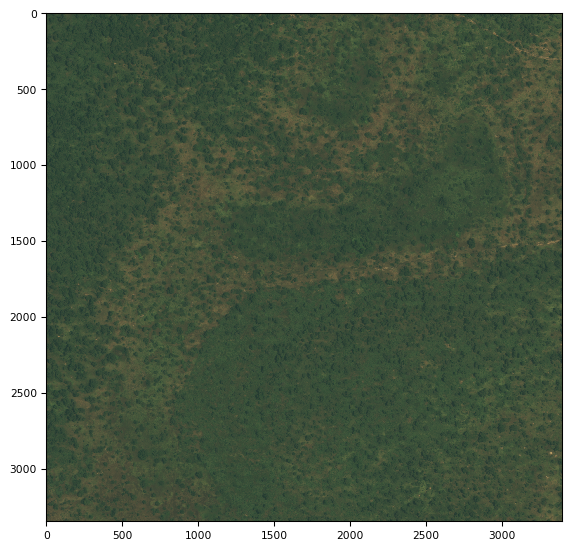

In [26]:
tiff.imshow(img_rgb[:,:,:])

## Plot masks

In [27]:
jaccard_coef(img_mask_pred, img_mask_true)

0.096418256866374147

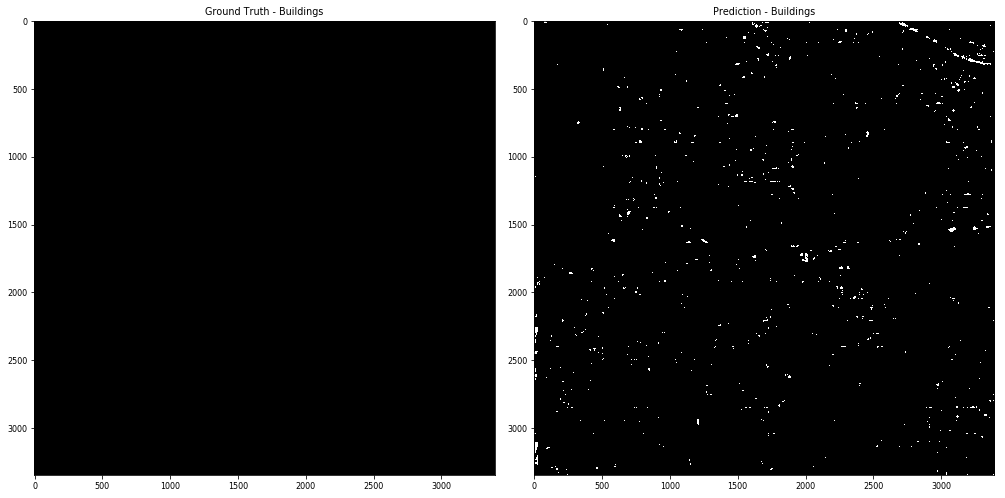

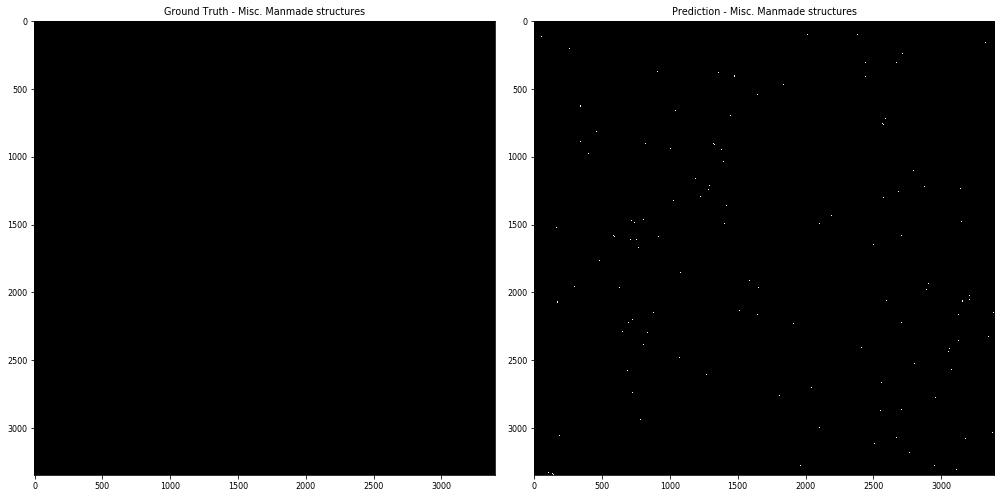

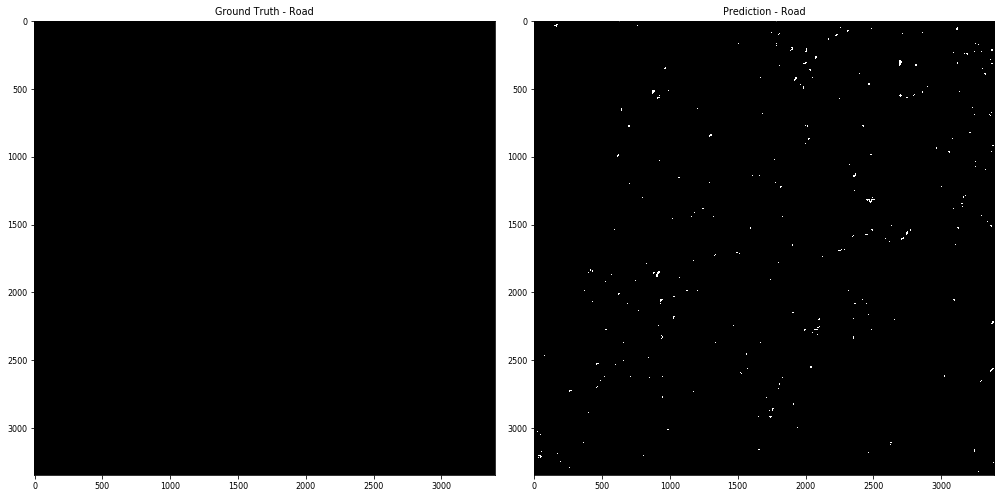

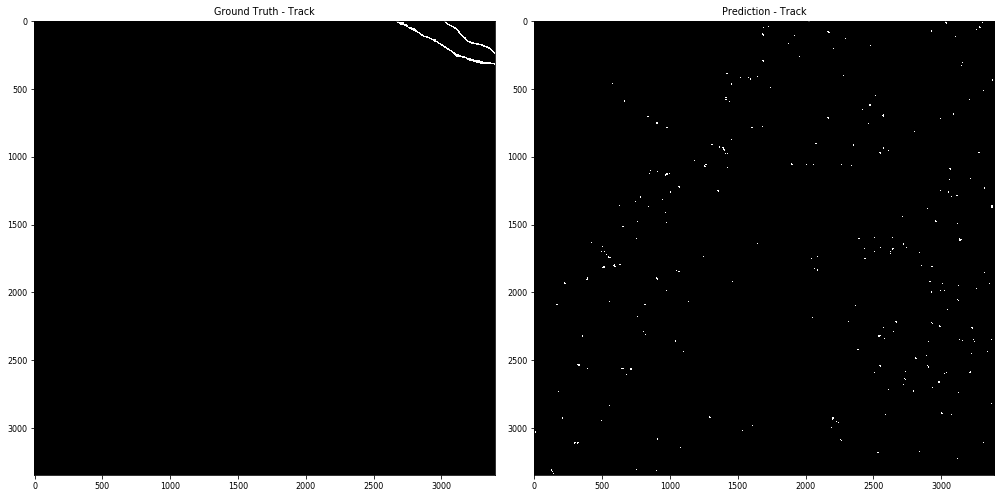

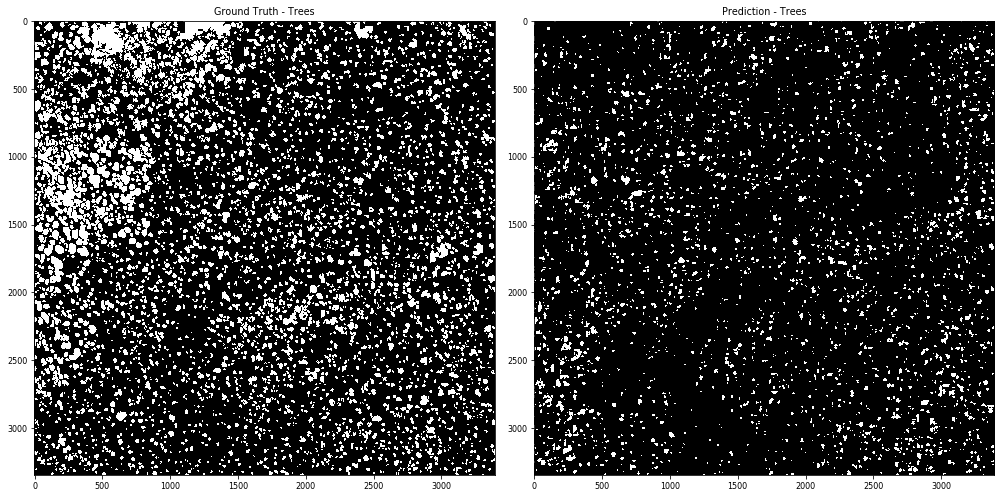

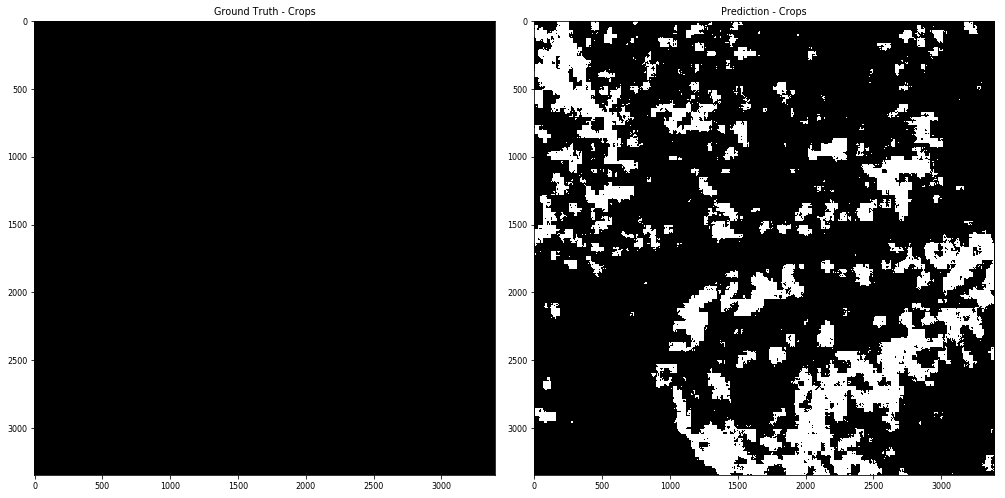

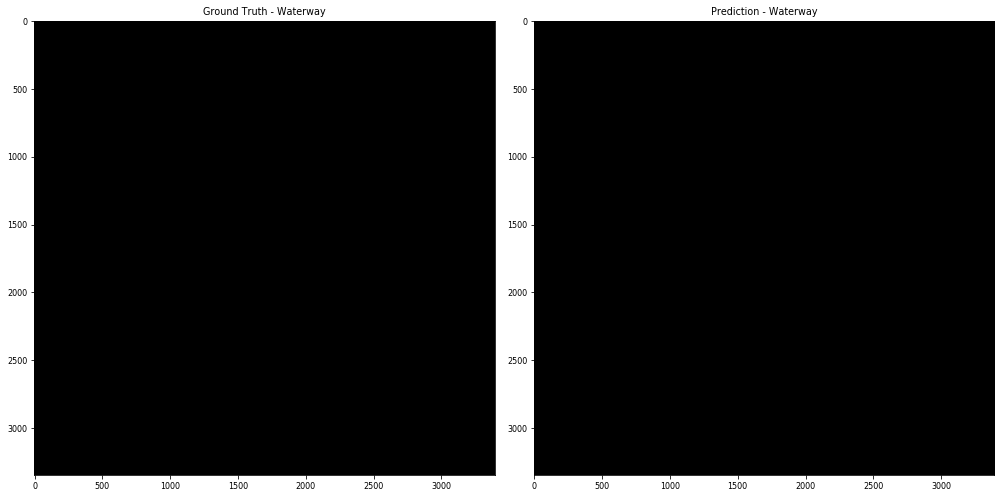

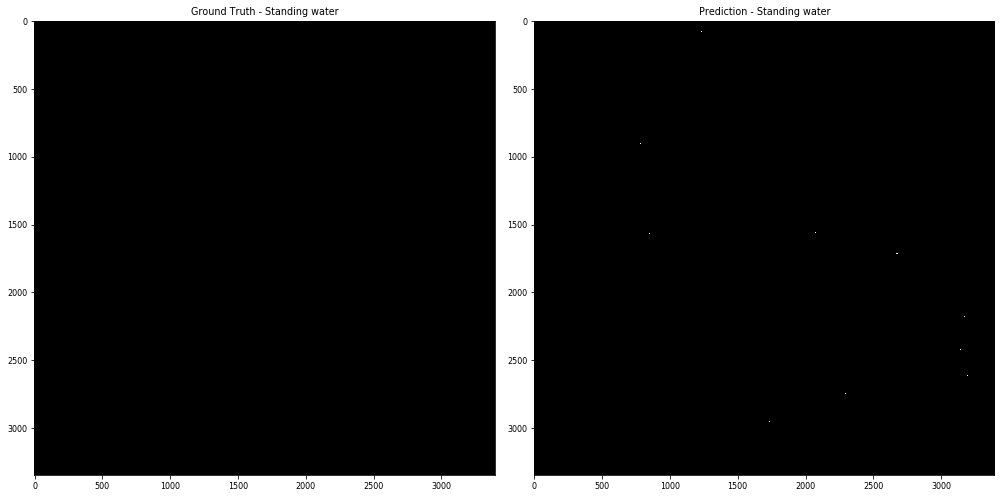

In [28]:
for i in range(nb_classes):
    if np.sum(img_mask_pred[:,:,i]) == 0 and np.sum(img_mask_true[:,:,i]) == 0:
        continue
    
    class_name = CLASSES_NAMES[i]
    plot_two_masks(img_mask_true[:,:,i], img_mask_pred[:,:,i], # 500:1500,1000:2000
        titles=['Ground Truth - {}'.format(class_name), 'Prediction - {}'.format(class_name)])

## Simplification

In [83]:
img_mask_pred_simplified = simplify_mask(img_mask_pred, kernel_size=5)

In [84]:
jaccard_coef(img_mask_pred_simplified, img_mask_true)

0.93463890184714882

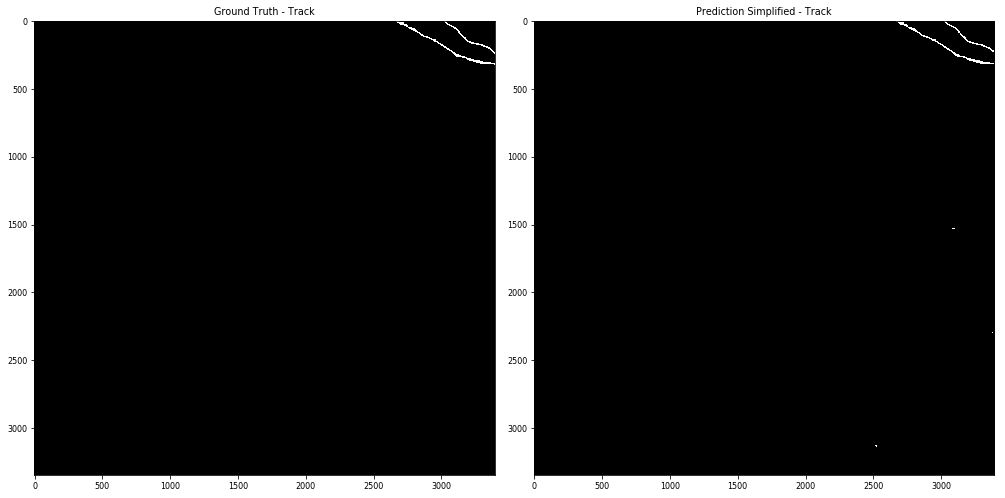

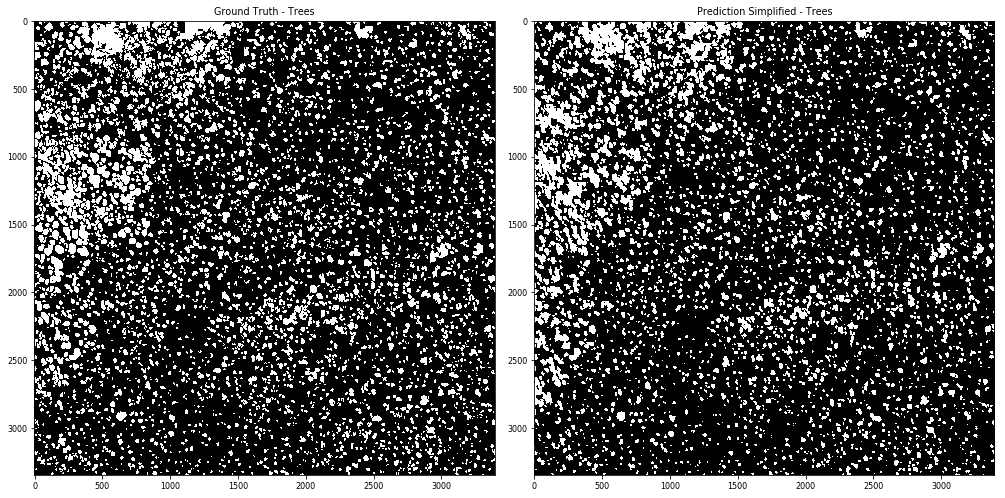

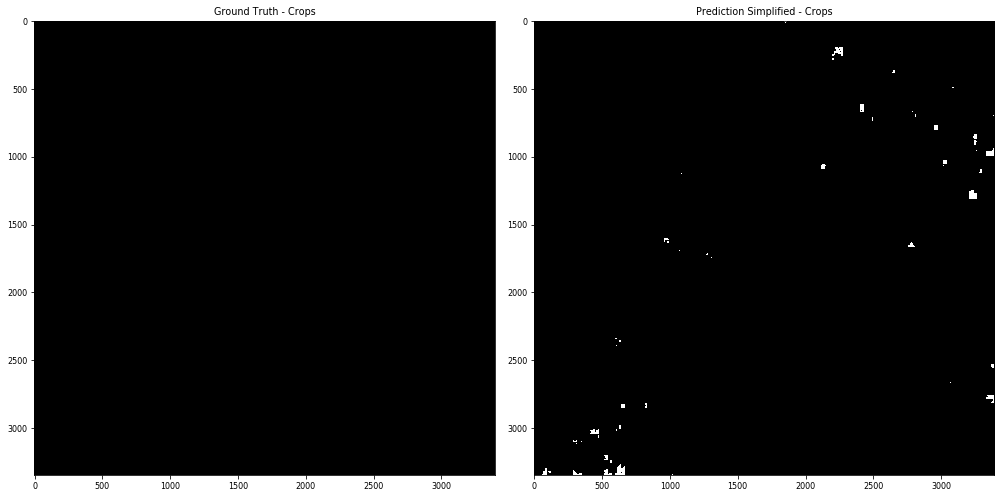

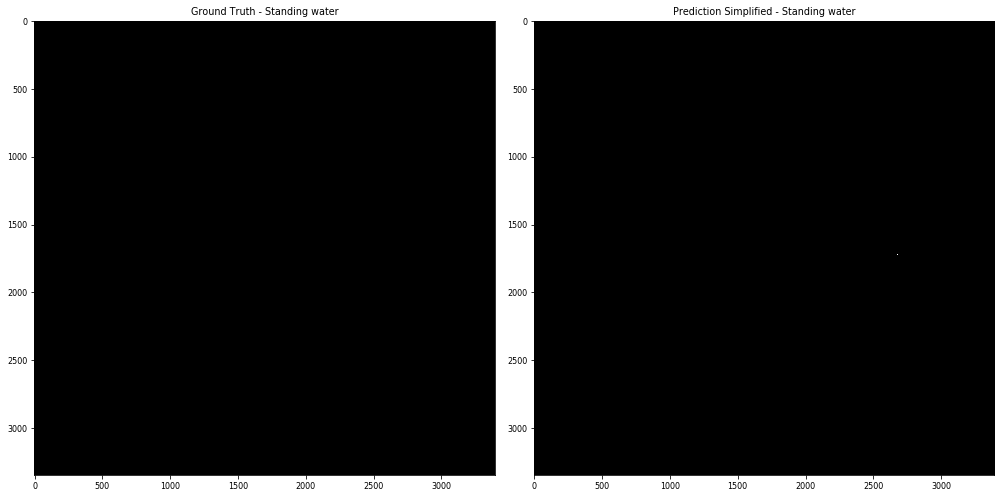

In [29]:
for i in range(nb_classes):
    if np.sum(img_mask_pred_simplified[:,:,i]) == 0 and np.sum(img_mask_true[:,:,i]) == 0:
        continue
    
    class_name = CLASSES_NAMES[i]
    plot_two_masks(img_mask_true[:,:,i], img_mask_pred_simplified[:,:,i], # 500:1500,1000:2000
        titles=['Ground Truth - {}'.format(class_name), 'Prediction Simplified - {}'.format(class_name)])

## Reconstruct polygons

In [119]:
def create_polygons_from_mask(mask, image_metadata, scale=True, min_area=1.0):
    poly = mask_to_polygons(mask, min_area=min_area, epsilon=1)
#     poly = mask_to_polygons_v2(mask, min_area=min_area)

    if scale:
        x_scaler = image_metadata['x_rgb_scaler']
        y_scaler = image_metadata['y_rgb_scaler']
        poly = shapely.affinity.scale(poly, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler, origin=(0, 0, 0))

    return poly

In [120]:
def create_image_polygons(img_masks, img_metadata, scale=True, skip_classes=None, min_areas = None):
    if img_masks is None:
        return {}

    if skip_classes is None:
        skip_classes = set()
        
    nb_classes = img_masks.shape[2]
    if min_areas is None:
        min_areas = {cls:1.0 for cls in range(nb_classes)}

    polygons = [
        create_polygons_from_mask(img_masks[:, :, class_id], img_metadata, scale, min_areas[class_id])
        for class_id in range(nb_classes) if class_id not in skip_classes
    ]

    polygons_dict = {
        class_id + 1: polygons[class_id]
        for class_id in range(nb_classes) if class_id not in skip_classes
        }
    return polygons_dict

In [37]:
img_poly_reconstructed = create_image_polygons(img_mask_true, img_metadata, scale=False)

Self-intersection at or near point 992.76923076923072 178.61538461538461
02-03-2017 12:05:03 : WARNING : geos : Self-intersection at or near point 992.76923076923072 178.61538461538461


In [38]:
img_mask_reconstructed = []
for class_type in sorted(img_poly_reconstructed.keys()):
    img_size = (img_metadata['height_rgb'], img_metadata['width_rgb'])
    polygons = img_poly_reconstructed[class_type]
    img_class_mask_reconstructed = create_mask_from_polygons(img_size, polygons)
    img_mask_reconstructed.append(img_class_mask_reconstructed)
    
img_mask_reconstructed = np.stack(img_mask_reconstructed, axis=-1)

In [39]:
jaccard_coef(img_mask_reconstructed, img_mask_true)

0.97061240170738394

## Reconstruct predicted mask

In [145]:
min_areas = {cls:1.0 for cls in range(nb_classes)}

In [146]:
min_areas[5] = 5000

In [147]:
img_poly_pred_reconstructed = create_image_polygons(img_mask_pred, img_metadata, scale=False, min_areas=min_areas)

Self-intersection at or near point 3223 1536
02-03-2017 12:57:24 : WARNING : geos : Self-intersection at or near point 3223 1536
Self-intersection at or near point 1885.8181818181818 2204.5454545454545
02-03-2017 12:57:25 : WARNING : geos : Self-intersection at or near point 1885.8181818181818 2204.5454545454545


In [148]:
img_mask_pred_reconstructed = []
for class_type in sorted(img_poly_pred_reconstructed.keys()):
    img_size = (img_metadata['height_rgb'], img_metadata['width_rgb'])
    polygons = img_poly_pred_reconstructed[class_type]
    img_class_mask_reconstructed = create_mask_from_polygons(img_size, polygons)
    img_mask_pred_reconstructed.append(img_class_mask_reconstructed)
    
img_mask_pred_reconstructed = np.stack(img_mask_pred_reconstructed, axis=-1)

In [149]:
jaccard_coef(img_mask_pred_reconstructed, img_mask_true)

0.65340291582086474

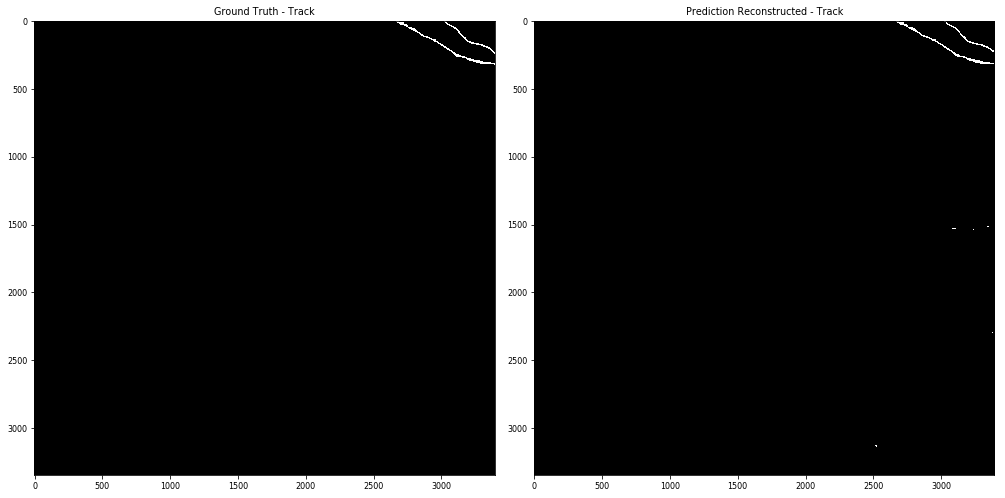

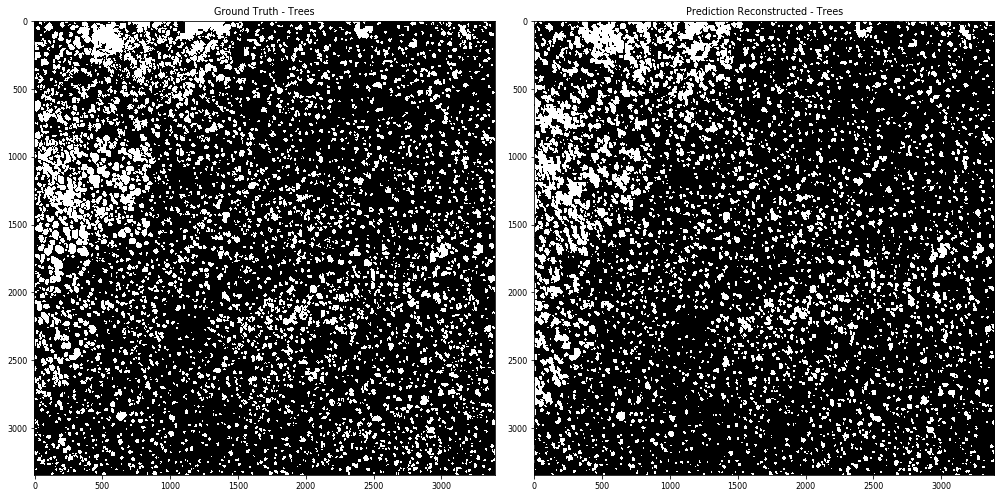

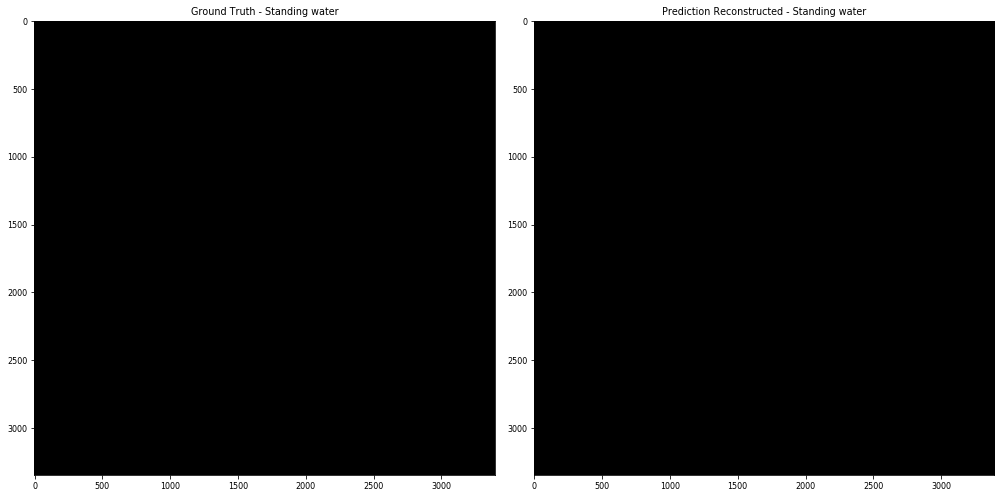

In [150]:
for i in range(nb_classes):
    if np.sum(img_mask_pred_reconstructed[:,:,i]) == 0 and np.sum(img_mask_true[:,:,i]) == 0:
        continue
    
    class_name = CLASSES_NAMES[i]
    plot_two_masks(img_mask_true[:,:,i], img_mask_pred_reconstructed[:,:,i], # 500:1500,1000:2000
        titles=['Ground Truth - {}'.format(class_name), 'Prediction Reconstructed - {}'.format(class_name)])

## Dilation

In [104]:
i = 3
class_name = CLASSES_NAMES[i]

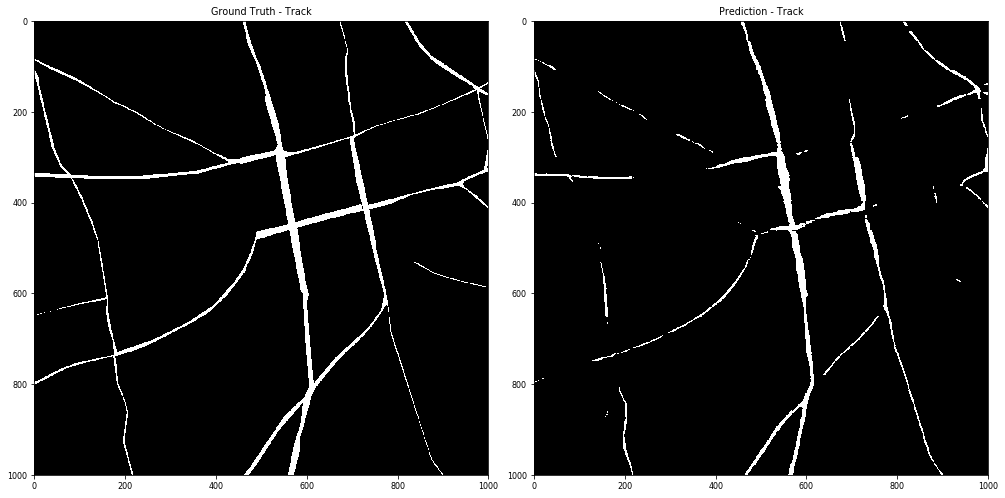

In [86]:
plot_two_masks(img_mask_true[500:1500,1000:2000,i], img_mask_pred[500:1500,1000:2000,i],
    titles=['Ground Truth - {}'.format(class_name), 'Prediction - {}'.format(class_name)])

In [105]:
jaccard_coef(img_mask_pred[:,:,i:i+1], img_mask_true[:,:,i:i+1])

0.39223828581583342

In [116]:
img_mask_pred_closed = close_mask(img_mask_pred, kernel_size=5)

In [117]:
jaccard_coef(img_mask_pred_closed[:,:,i:i+1], img_mask_true[:,:,i:i+1])

0.39534799394733372

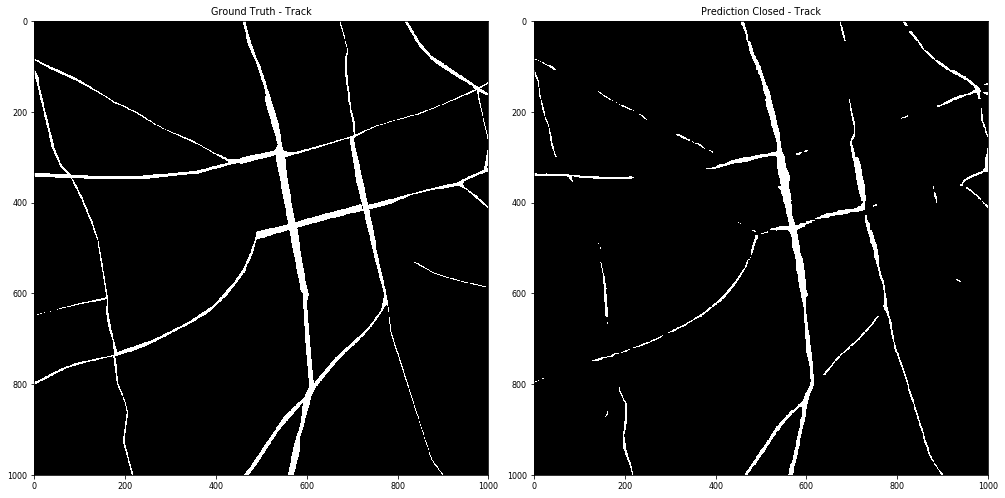

In [118]:
plot_two_masks(img_mask_true[500:1500,1000:2000,i], img_mask_pred_closed[500:1500,1000:2000,i],
    titles=['Ground Truth - {}'.format(class_name), 'Prediction Closed - {}'.format(class_name)])

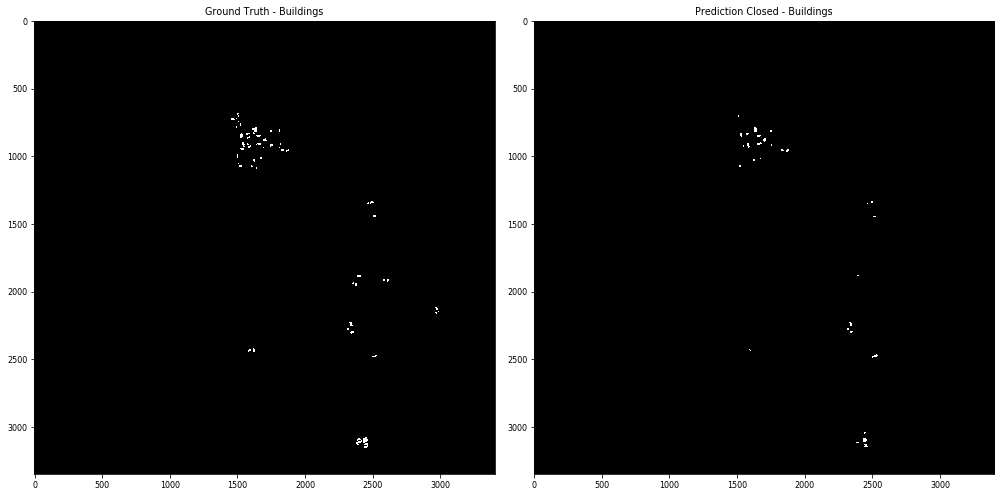

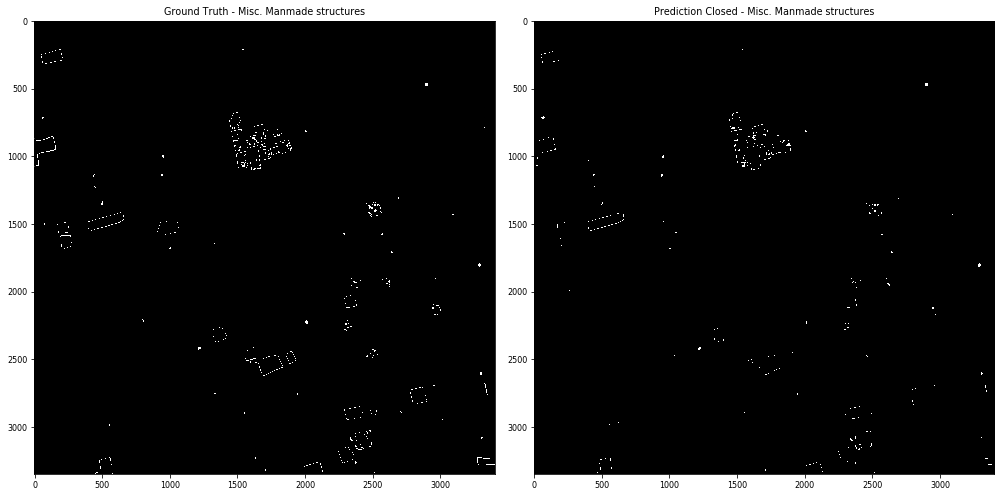

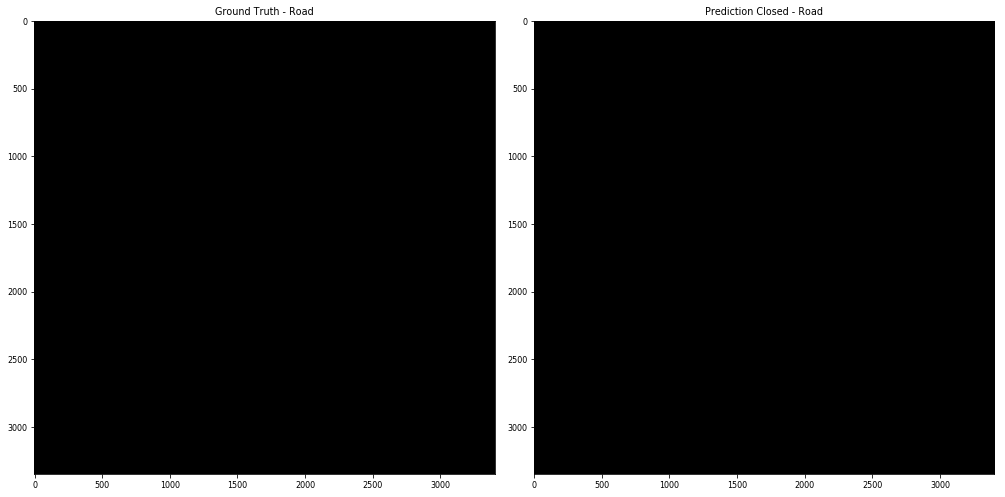

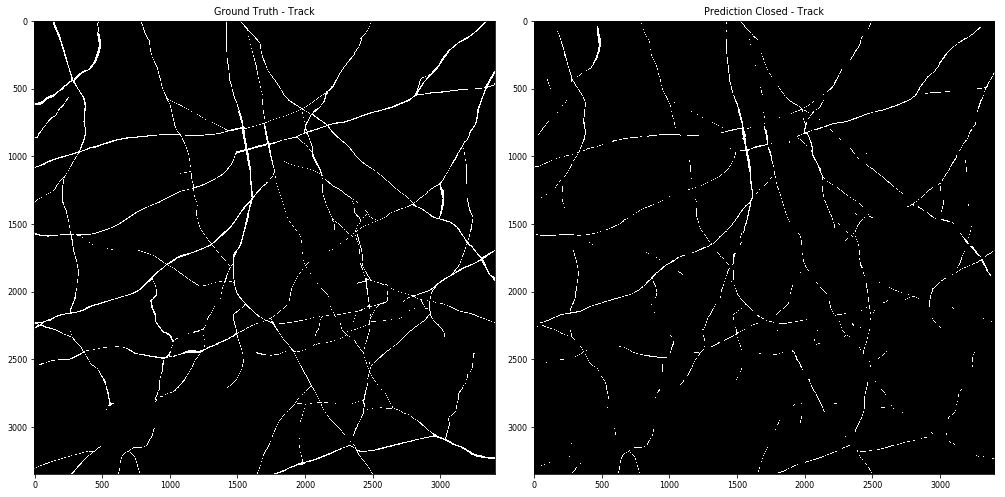

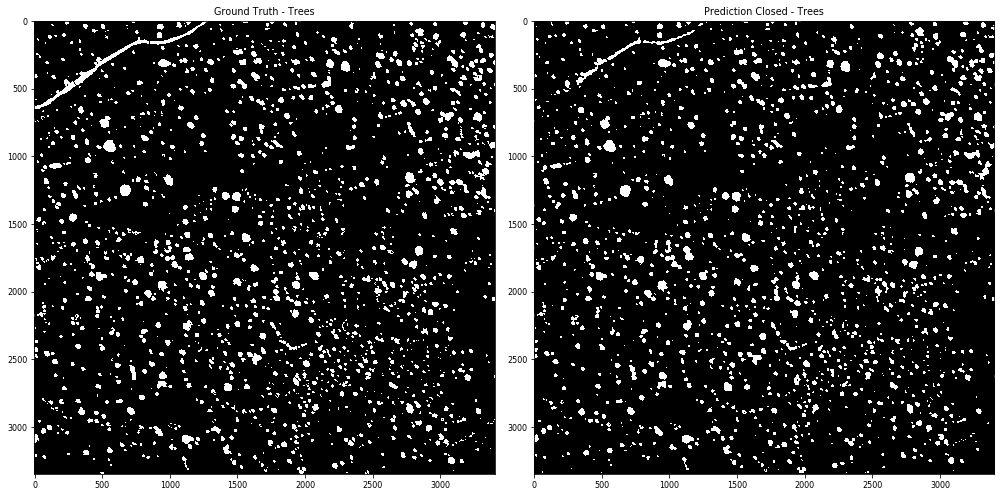

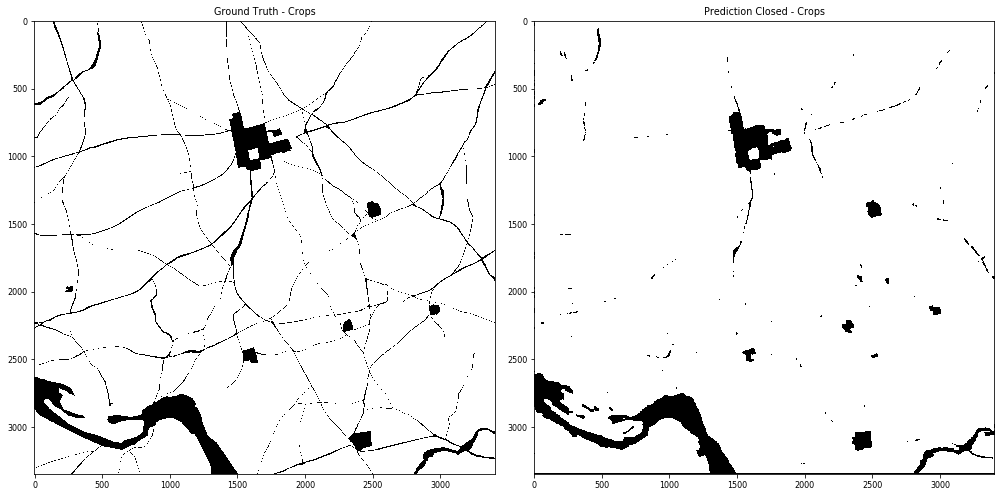

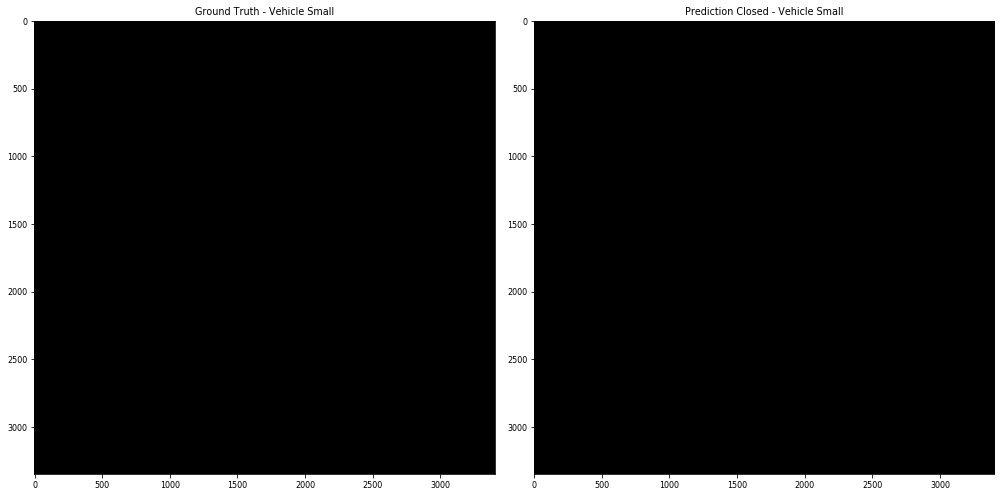

In [91]:
for i in range(nb_classes):
    if np.sum(img_mask_pred_closed[:,:,i]) == 0 and np.sum(img_mask_true[:,:,i]) == 0:
        continue
    
    class_name = CLASSES_NAMES[i]
    plot_two_masks(img_mask_true[:,:,i], img_mask_pred_closed[:,:,i], # 500:1500,1000:2000
        titles=['Ground Truth - {}'.format(class_name), 'Prediction Closed - {}'.format(class_name)])

## Calc mean over all images

In [151]:
jaccards = []
for img_id in images_train:
    # true
    img_metadata = images_metadata[img_id]
    img_poly_true = images_metadata_polygons[img_id]
    img_mask_true = images_masks_stacked[img_id]
    
    # predictions
    mask_filename = os.path.join(IMAGES_PREDICTION_MASK_DIR, '{0}_{1}.npy'.format(img_id, model_name))
    img_mask_pred = np.load(mask_filename).astype(np.uint8)

    # morph operations
    img_mask_pred_simplified = simplify_mask(img_mask_pred, kernel_size=5)
    img_mask_pred_closed = close_mask(img_mask_pred, kernel_size=7)
    
    # reconstructed
    img_poly_pred_reconstructed = create_image_polygons(img_mask_pred, img_metadata, scale=False, min_areas=min_areas)
    img_mask_pred_reconstructed = []
    for class_type in sorted(img_poly_pred_reconstructed.keys()):
        img_size = (img_metadata['height_rgb'], img_metadata['width_rgb'])
        polygons = img_poly_pred_reconstructed[class_type]
        img_class_mask_reconstructed = create_mask_from_polygons(img_size, polygons)
        img_mask_pred_reconstructed.append(img_class_mask_reconstructed)

    img_mask_pred_reconstructed = np.stack(img_mask_pred_reconstructed, axis=-1)   
    
    jac_pred = jaccard_coef(img_mask_pred, img_mask_true)
    jac_pred_simplified = jaccard_coef(img_mask_pred_simplified, img_mask_true)
    jac_pred_closed = jaccard_coef(img_mask_pred_closed, img_mask_true)    
    jac_pred_reconstructed = jaccard_coef(img_mask_pred_reconstructed, img_mask_true)
    
    jaccards.append((jac_pred, jac_pred_simplified, jac_pred_closed, jac_pred_reconstructed))
    logging.info('Pred: %s, Simplified: %s, Closed: %s, Reconstructed: %s', 
                 jac_pred, jac_pred_simplified, jac_pred_closed, jac_pred_reconstructed)
    
jaccards_mean = np.mean(jaccards, axis=0)
logging.info('Mean - Pred: %s, Simplified: %s, Closed: %s, Reconstructed: %s', 
             jaccards_mean[0], jaccards_mean[1], jaccards_mean[2], jaccards_mean[3])

Self-intersection at or near point 3167.1052631578946 617.9473684210526
02-03-2017 12:59:31 : WARNING : geos : Self-intersection at or near point 3167.1052631578946 617.9473684210526
Self-intersection at or near point 1133.6666666666667 473.66666666666669
02-03-2017 12:59:32 : WARNING : geos : Self-intersection at or near point 1133.6666666666667 473.66666666666669
02-03-2017 12:59:37 : INFO : <ipython-input-151-84d06ca030db> : Pred: 0.620096716051, Simplified: 0.620887746218, Closed: 0.620032544135, Reconstructed: 0.61630666107
Self-intersection at or near point 2016.375 2183.5
02-03-2017 12:59:45 : WARNING : geos : Self-intersection at or near point 2016.375 2183.5
Self-intersection at or near point 2571.8571428571427 616.14285714285711
02-03-2017 12:59:46 : WARNING : geos : Self-intersection at or near point 2571.8571428571427 616.14285714285711
02-03-2017 12:59:51 : INFO : <ipython-input-151-84d06ca030db> : Pred: 0.720432585904, Simplified: 0.72188776761, Closed: 0.721906035242, Re

### Smart closing

In [53]:
jaccards = []
for img_id in images_train:
    # true
    img_metadata = images_metadata[img_id]
    img_poly_true = images_metadata_polygons[img_id]
    img_mask_true = images_masks_stacked[img_id]
    
    # predictions
    mask_filename = os.path.join(IMAGES_PREDICTION_MASK_DIR, '{0}_{1}.npy'.format(img_id, model_name))
    img_mask_pred = np.load(mask_filename).astype(np.uint8)

    # close tracks and roads ()
    img_mask_pred_closed_tmp = close_mask(img_mask_pred, kernel_size=5)
    img_mask_pred_closed = np.copy(img_mask_pred)
    img_mask_pred_closed[:,:,[2,3]] = img_mask_pred_closed_tmp[:,:,[2,3]]

    jac_pred = jaccard_coef(img_mask_pred, img_mask_true)
    jac_pred_closed = jaccard_coef(img_mask_pred_closed, img_mask_true)    
    
    jaccards.append((jac_pred, jac_pred_closed))
    logging.info('Image: %s, Pred: %s, Closed: %s', img_id, jac_pred, jac_pred_closed)
    
jaccards_mean = np.mean(jaccards, axis=0)
logging.info('Mean - Pred: %s, Closed: %s', jaccards_mean[0], jaccards_mean[1])

02-03-2017 12:14:31 : INFO : <ipython-input-53-e0df4bfbed97> : Image: 6010_1_2, Pred: 0.620096716051, Closed: 0.619433387809
02-03-2017 12:14:42 : INFO : <ipython-input-53-e0df4bfbed97> : Image: 6010_4_2, Pred: 0.720432585904, Closed: 0.719817790293
02-03-2017 12:14:51 : INFO : <ipython-input-53-e0df4bfbed97> : Image: 6010_4_4, Pred: 0.711706227861, Closed: 0.711704863389
02-03-2017 12:15:00 : INFO : <ipython-input-53-e0df4bfbed97> : Image: 6040_1_0, Pred: 0.665843138235, Closed: 0.665550571929
02-03-2017 12:15:09 : INFO : <ipython-input-53-e0df4bfbed97> : Image: 6040_1_3, Pred: 0.649426545924, Closed: 0.649264891151
02-03-2017 12:15:19 : INFO : <ipython-input-53-e0df4bfbed97> : Image: 6040_2_2, Pred: 0.679308521193, Closed: 0.679163271853
02-03-2017 12:15:29 : INFO : <ipython-input-53-e0df4bfbed97> : Image: 6040_4_4, Pred: 0.560003534935, Closed: 0.558344078047
02-03-2017 12:15:37 : INFO : <ipython-input-53-e0df4bfbed97> : Image: 6060_2_3, Pred: 0.937553387507, Closed: 0.937641193331


# Calc min areas of the polygons on the training set

In [73]:
areas = [[] for _ in range(nb_classes)]
for img_id in images_train:
    # true
    img_metadata = images_metadata[img_id]
    img_poly_true = images_metadata_polygons[img_id]
    
    for cls_idx in range(nb_classes):
        cls_multipoly = shapely.wkt.loads(img_poly_true[cls_idx + 1]['ploy_rgb_scaled'])
        for cls_poly in cls_multipoly:
            cls_area = cls_poly.area
            if cls_area >= 0.0000001:
                areas[cls_idx].append(cls_area)

In [74]:
for cls_idx, cls_name in enumerate(CLASSES_NAMES):
    print('Class: {}, {} - min: {:.5f}, max: {:.5f}, median: {:.5f}'.format(
        cls_name, cls_idx, np.min(areas[cls_idx]), np.max(areas[cls_idx]), np.median(areas[cls_idx])))

Class: Buildings, 0 - min: 0.00670, max: 40015.21042, median: 441.34091
Class: Misc. Manmade structures, 1 - min: 0.00086, max: 20916.28419, median: 66.90133
Class: Road, 2 - min: 668.66129, max: 484753.94305, median: 105557.38292
Class: Track, 3 - min: 0.03604, max: 1035099.48460, median: 2359.29501
Class: Trees, 4 - min: 0.00000, max: 689473.70484, median: 276.64478
Class: Crops, 5 - min: 0.09664, max: 5246407.39793, median: 60442.56481
Class: Waterway, 6 - min: 55.36978, max: 775557.06688, median: 934.85605
Class: Standing water, 7 - min: 0.10137, max: 53817.82524, median: 119.16531
Class: Vehicle Large, 8 - min: 4.11265, max: 864.65251, median: 107.99309
Class: Vehicle Small, 9 - min: 0.03525, max: 968.43947, median: 23.16868
